<a href="https://colab.research.google.com/github/Calebmonroe/DS2/blob/main/HW_3_Caleb_Monroe_FINAL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Homework #3 - Regularized models and Gradient Descent

This assignment will follow our discussions in class about regularized linear regression models, stratified sampling, and gradient descent methods.  

## Imports and Function Definitions

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import seaborn as sns;
sns.axes_style("whitegrid")
sns.set_context("paper")
from sklearn.linear_model import SGDRegressor
np.random.seed(42)

In [3]:
import sklearn.metrics as metrics
def regression_results(y_true, y_pred):

    # Regression metrics
    explained_variance=metrics.explained_variance_score(y_true, y_pred)
    mean_absolute_error=metrics.mean_absolute_error(y_true, y_pred)
    mse=metrics.mean_squared_error(y_true, y_pred)
    mean_squared_log_error=metrics.mean_squared_log_error(y_true, y_pred)
    median_absolute_error=metrics.median_absolute_error(y_true, y_pred)
    r2=metrics.r2_score(y_true, y_pred)

    print('explained_variance: ', round(explained_variance,4))
    print('mean_absolute_error: ', round(mean_absolute_error,4))
    print('mean_squared_log_error: ', round(mean_squared_log_error,4))
    print('r2: ', round(r2,4))
    print('MAE: ', round(mean_absolute_error,4))
    print('MSE: ', round(mse,4))
    print('RMSE: ', round(np.sqrt(mse),4))

## FEV_Lung Data and Visualizations
#### DATA DESCRIPTION:
The data are from n = 654 children between 3 and 19 years old. The data features include forced expiratory volume (**FEV**, a measure of how much air somebody can forcibly exhale from their lungs), subject **Age** (years), subject height (inches), sex (f/m), and whether they smoke (n/y).  Data source: The data here are a part of dataset given in
* Kahn, Michael (2005). "An Exhalent Problem for Teaching Statistics", The Journal of Statistical Education, 13(2) [link](http://jse.amstat.org/v13n2/datasets.kahn.html)

Using this dataset, the task is to predict the FEV

* **Age**: Child's age [years]
* **fev**: Lung Volume [liters]
* **ht**: Child's height [in]
* **sex**: (f/m)
* **smoke**: (n/y)


In [4]:
web_path = '' #if downloaded data to the current folder
web_path = 'http://public.gettysburg.edu/~rjohnson/ds325/' #if using data over web
df = pd.read_csv(web_path+'fev_lung.csv')
df.head()

,age,fev,ht,sex,smoke
0,9,1.708,57.0,0,0
1,8,1.724,67.5,0,0
2,7,1.720,54.5,0,0
3,9,1.558,53.0,1,0
4,9,1.895,57.0,1,0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 654 entries, 0 to 653
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   age     654 non-null    int64  
 1   fev     654 non-null    float64
 2   ht      654 non-null    float64
 3   sex     654 non-null    int64  
 4   smoke   654 non-null    int64  
dtypes: float64(2), int64(3)
memory usage: 25.7 KB


In [6]:
df.describe()

,age,fev,ht,sex,smoke
count,654.000000,654.000000,654.000000,654.000000,654.000000
mean,9.931193,2.636780,61.143578,0.513761,0.099388
std,2.953935,0.867059,5.703513,0.500193,0.299412
min,3.000000,0.791000,46.000000,0.000000,0.000000
25%,8.000000,1.981000,57.000000,0.000000,0.000000
50%,10.000000,2.547500,61.500000,1.000000,0.000000
75%,12.000000,3.118500,65.500000,1.000000,0.000000
max,19.000000,5.793000,74.000000,1.000000,1.000000


The data for sex and smoke are both binary

0 for female, 1 for male

0 for nonsmoker, 1 for smoker

## Prepare the data (train/test split), rescaling

In [7]:
from sklearn.model_selection import train_test_split

#setting random state should ensure same train/test set each time
train_set, test_set = train_test_split(df, test_size=0.2, random_state=42)

In [8]:
# just checking to be sure overall statistical distributions are similar
train_set.describe(), test_set.describe()

(              age         fev          ht         sex       smoke
 count  523.000000  523.000000  523.000000  523.000000  523.000000
 mean     9.938815    2.620193   61.170937    0.504780    0.099426
 std      2.853391    0.856641    5.678247    0.500456    0.299520
 min      3.000000    0.791000   46.500000    0.000000    0.000000
 25%      8.000000    1.989000   57.500000    0.000000    0.000000
 50%     10.000000    2.504000   61.500000    1.000000    0.000000
 75%     12.000000    3.096000   65.000000    1.000000    0.000000
 max     19.000000    5.638000   74.000000    1.000000    1.000000,
               age        fev          ht         sex       smoke
 count  131.000000  131.00000  131.000000  131.000000  131.000000
 mean     9.900763    2.70300   61.034351    0.549618    0.099237
 std      3.337099    0.90783    5.824085    0.499442    0.300127
 min      3.000000    1.07200   46.000000    0.000000    0.000000
 25%      8.000000    1.95750   57.000000    0.000000    0.000000


In [9]:
# now, split up the training data by feature

#convert into a numpy array;
#extra brackets are for sklearn because it wants a 2D array
xsk1_train = np.array(train_set[['age']])
xsk2_train = np.array(train_set[['ht']])
xsk3_train = np.array(train_set[['sex']])
xsk4_train = np.array(train_set[['smoke']])
ysk_train = np.array(train_set[['fev']])

# and do the same with your test data
xsk1_test = np.array(test_set[['age']])
xsk2_test = np.array(test_set[['ht']])
xsk3_test = np.array(test_set[['sex']])
xsk4_test = np.array(test_set[['smoke']])
ysk_test = np.array(test_set[['fev']])

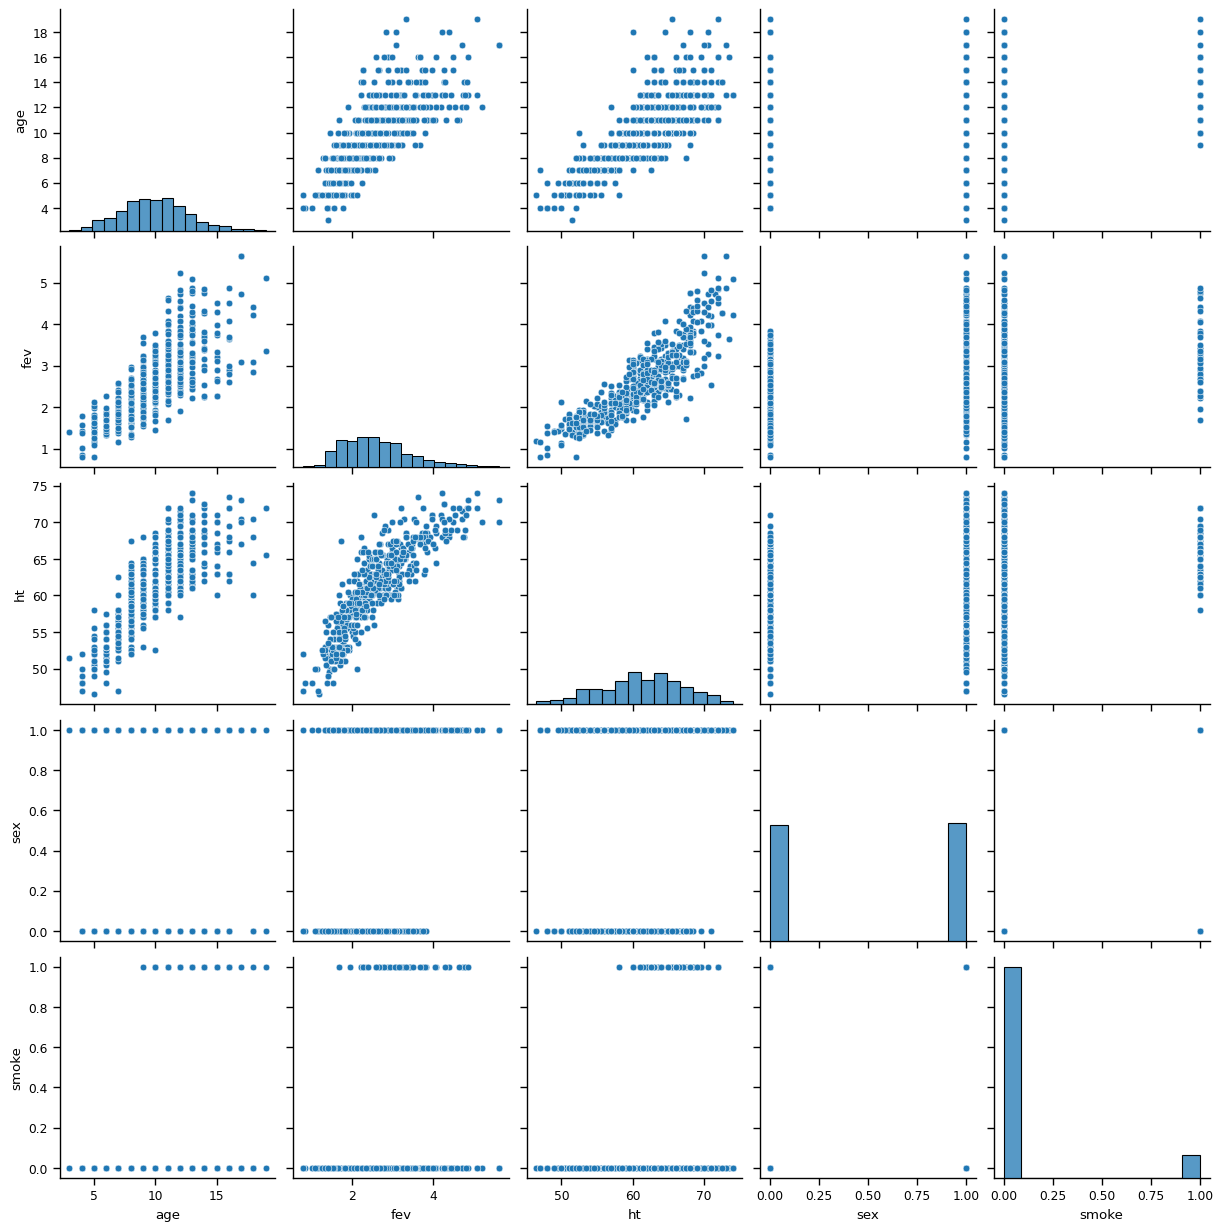

In [10]:
# take a look at any obvious linear correlations
sns.pairplot(train_set)

<Axes: >

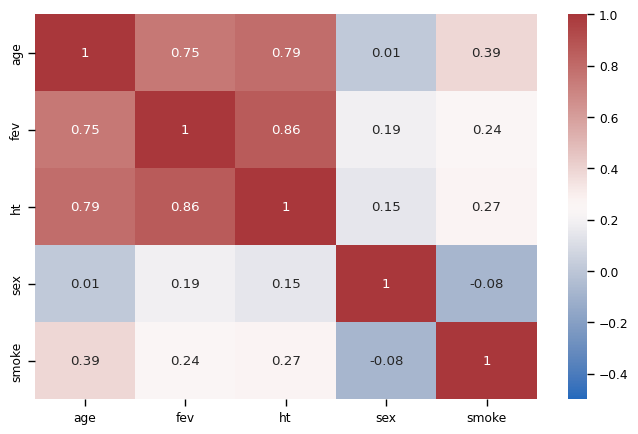

In [11]:
correlation_matrix = train_set.corr().round(2)
fig, ax = plt.subplots(figsize=(8.1, 5))
sns.heatmap(data=correlation_matrix, annot=True,vmin=-0.5,vmax=1,cmap='vlag')# annot = True to print the values inside the square

We select those features which have a high correlation with our target variable **FEV**. By looking at the correlation matrix we can see that **age** and **ht** have a strong positive correlations with **FEV** (0.75) and (0.86) respectively.

Not surprising, but potentially interesting, they also have a strong positive correlation with one another (0.79)

In class, we examined a univariate model which predicted **FEV** based on a persons's **age**.

Here you are going to examine **FEV** (y) vs. **ht** (x)

## Exercise 1 - Univariate Linear Regression stratified according to age

Using the method outlined in class04, **prepare a linear regression of FEV vs. ht**  

Be sure to:  
* use **stratified sampling on the 'age' feature** in your train/test split

* **regularize your data using the StandardScaler method**

* **transform, fit, then inverse transform** your model's predictions

* report your **model parameters and their standard errors** (part of this should include a plot of your training data and fit)

* report on the quality of your model fit using **prediction and cross validation** (this needs to be done on the test data set)

* quantitatively and qualitatively compare this univariate regression model's predictions to that obtained in class (which also used the dataset stratified according to age)

### Student solution

In [12]:
# Enter your solution here
#importing necessary tools for regression preparation
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression

#Used stratefied sampling on age in the train/test split
strat_train_set, strat_test_set = train_test_split(df, test_size=0.2, stratify=df['age'], random_state=42)

#Regularize the data using the Standarscaler method
target_scaler_fev_train = StandardScaler(with_mean=True, with_std=False)
scaled_fev_train = target_scaler_fev_train.fit_transform(strat_train_set[['fev']])

target_scaler_ht_train = StandardScaler(with_mean=True, with_std=False)
scaled_ht_train = target_scaler_ht_train.fit_transform(strat_train_set[["ht"]])

target_scaler_fev_test = StandardScaler(with_mean=True, with_std=False)
scaled_fev_test = target_scaler_fev_test.fit_transform(strat_test_set[["fev"]])

target_scaler_ht_test = StandardScaler(with_mean=True, with_std=False)
scaled_ht_test = target_scaler_ht_test.fit_transform(strat_test_set[["ht"]])

#fit the newly scaled variables together using linear regression
model = LinearRegression()
result = model.fit(scaled_ht_train,scaled_fev_train)

#perform inverse transformation of prediction of scaled test
scaled_fev_pred = model.predict(scaled_ht_test)
unscaled_fev_pred = target_scaler_fev_test.inverse_transform(scaled_fev_pred)

#report model perameters and standard errors
y_true = (strat_test_set[["fev"]])
regression_results(y_true, unscaled_fev_pred)

explained_variance:  0.7427
mean_absolute_error:  0.3492
mean_squared_log_error:  0.0144
r2:  0.7427
MAE:  0.3492
MSE:  0.2155
RMSE:  0.4642


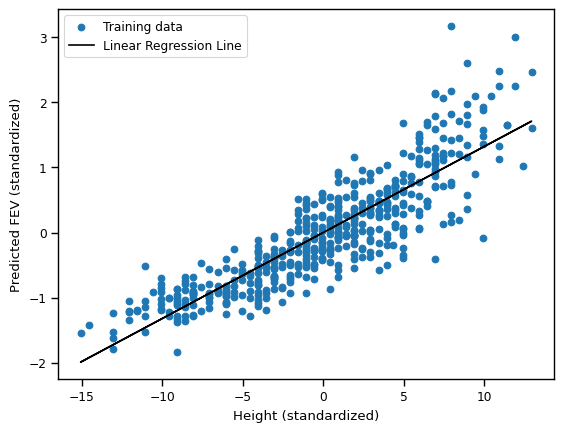

In [13]:
plt.scatter(scaled_ht_train, scaled_fev_train, label = 'Training data')#creating a plot of the data
plt.plot(scaled_ht_train, model.predict(scaled_ht_train), color = 'black', label = 'Linear Regression Line')#graphing regression line from model
plt.xlabel('Height (standardized)')
plt.ylabel('Predicted FEV (standardized)')
plt.legend()
plt.show()

In [14]:
from sklearn.model_selection import cross_val_score #importing new necessary materials
from sklearn.pipeline import make_pipeline

model_xn = scaled_ht_test; model_yn = scaled_fev_test#reporting on the quality using cross validation

lin_reg = make_pipeline(model)
lin_reg.fit(model_xn, model_yn)

linreg_rmses = -cross_val_score(lin_reg, model_xn, model_yn, scoring="neg_root_mean_squared_error", cv=10) #using cross validation score
pd.Series(linreg_rmses).describe()

count    10.000000
mean      0.457160
std       0.112176
min       0.321060
25%       0.380587
50%       0.432772
75%       0.487966
max       0.665244
dtype: float64

Quantitative and qualitative comparison of this univariate regression model's predictions to that obtained in class: The class model's predictions reported an R squared value of .5755 whereas the model created above reports an R squared value of .7427. In other words, the model in class accounts for 57.55% of the variance in FEV and the model above explains 74.27% of the variance. The cross validation scores of each model are also very useful. The mean for the in-class model is 0.56, whereas the mean for this model is 0.45. In this case, a lower mean is desireable because it shows that the above models predictions are relatively accurate to the folded data within cross-validation. In simple terms, this model responds better to new data than the in-class model, making it the better, more effective model in this case. This means that using height as the independent variable in the regression gives more accurate predictions and is better at estimating FEV than age. Qualitatively, the scatter plot and regression line above seems to describe the data in a clear and effective way by using the predictive model that was created.

## Exercise 2 - Multivariate Linear Regression stratified according to age

**Perform a multivariate regression of FEV using all available features (age, ht, sex, smoke)**

Be sure to:

* use **stratified sampling on the 'age' feature** in your train/test split

* **regularize your data using the StandardScaler method**

* **transform, fit, then inverse transform** your model's predictions

* report your **model parameters and their standard errors** (part of this should include a plot of your training data and fit)

* report on the quality of your model fit using **prediction and cross validation** (this needs to be done on the test data set)

* quantitatively and qualitatively compare this multivariate regression model's predictions to those obtained in class (which used the dataset stratified according to age), and your resulting model from Exercise 1


### Student solution

In [15]:
# Enter your solution here
#Used stratefied sampling on age in the train/test split
strat_train_set, strat_test_set = train_test_split(df, test_size=0.2, stratify=df['age'], random_state=42)

#Regularize the data using the Standarscaler method
target_scaler_fev_train = StandardScaler(with_mean=True, with_std=False)
scaled_fev_train = target_scaler_fev_train.fit_transform(strat_train_set[['fev']])

target_scaler_all_train = StandardScaler(with_mean=True, with_std=False)
scaled_all_train = target_scaler_all_train.fit_transform(strat_train_set[['ht','age', 'sex', 'smoke']])

target_scaler_fev_test = StandardScaler(with_mean=True, with_std=False)
scaled_fev_test = target_scaler_fev_test.fit_transform(strat_test_set[["fev"]])

target_scaler_all_test = StandardScaler(with_mean=True, with_std=False)
scaled_all_test = target_scaler_all_test.fit_transform(strat_test_set[['ht','age', 'sex', 'smoke']])

#fit the newly scaled variables together using linear regression
model = LinearRegression()
model.fit(scaled_all_train,scaled_fev_train)

#perform inverse transformation of prediction of scaled test
scaled_fev_pred = model.predict(scaled_all_test)
unscaled_fev_pred = target_scaler_fev_test.inverse_transform(scaled_fev_pred)

#report model perameters and standard errors
y_true = (strat_test_set[["fev"]])
regression_results(y_true, unscaled_fev_pred)

explained_variance:  0.7772
mean_absolute_error:  0.33
mean_squared_log_error:  0.0123
r2:  0.7772
MAE:  0.33
MSE:  0.1866
RMSE:  0.432


In [16]:
model_xn = scaled_all_test; model_yn = scaled_fev_test #reporting on the quality using cross validation

lin_reg = make_pipeline(model)
lin_reg.fit(model_xn, model_yn)

linreg_rmses = -cross_val_score(lin_reg, model_xn, model_yn, scoring="neg_root_mean_squared_error", cv=10) #using cross validation score
pd.Series(linreg_rmses).describe()

count    10.000000
mean      0.431518
std       0.091927
min       0.301145
25%       0.397651
50%       0.414309
75%       0.454825
max       0.596489
dtype: float64

# Quick note regarding my plot below:
I found it very difficult to plot a model which had multiple independent variables. I recieved several errors and the plots that I eventually recieved were not representative of the model and variables. I was able to read more about plots in multivariate regression, and it seems that I would need to create a plot with three dimentions in order to represent all of the data; however, I am unsure how to complete this. I tried to create 4 different plots but was unable to plot the regression line on each. I appologize for my confusion but I believe that this graph is the best representation out of all of the solutions I tried.

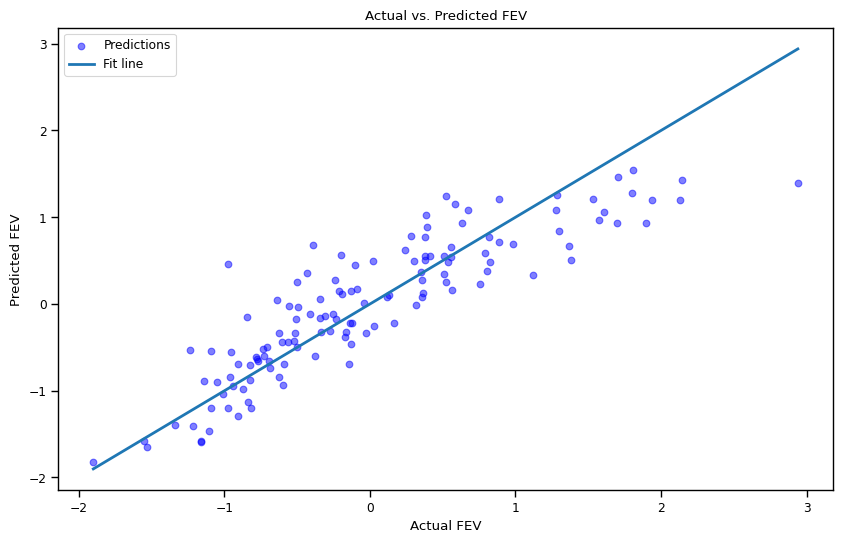

In [17]:
plt.figure(figsize=(10, 6))#created a plot of the  actual FEV values and predicted FEV values
plt.scatter(scaled_fev_test, scaled_fev_pred, alpha=0.5, color='b', label='Predictions') #plotting regression line
plt.plot([scaled_fev_test.min(), scaled_fev_test.max()], [scaled_fev_test.min(), scaled_fev_test.max()], lw=2, label='Fit line')
plt.title('Actual vs. Predicted FEV')
plt.xlabel('Actual FEV')
plt.ylabel('Predicted FEV')
plt.legend()
plt.show()

# Quantitative and qualitative comparison of this univariate regression model's predictions to that obtained in class and the model in question 1:
The R squared value for my model in question 2 is 0.7772 which is better than both of the other two models previously discussed. This means that 77.72% of the variance is explained in this model. Additionally, the mean after running the cross validation score is reported as about .43, which is slightly smaller than the means of the other models, which is a positive sign. In general, this model performs better than the previous 2, which shows that all 4 independent variables are better predictors for FEV than solely using age or height. Qualitatively, the plot above shows the predicted FEV graphed alongside the actual FEV and the fit line demonstrates the overall trajectory of the predictive model.

##Mastery Level Question 1

Qualitatively and quantitatively compare your models to the findings in the paper (see the data description); they perform several multivariate combinations

### Student Mastery solution 1

In [18]:
# Enter your solution here

## Mastery Level Question 2 - Custom data features

That there exists a strong correlation between **ht** and **age** should not be surprising.  As demonstrated in the CA housing data in Ch. 2 (p. 66-67 in your book), feature combinations can prove to be more useful than either of the features alone.  Create a combination of the age/ht feature, and use that feature in a multivariate regression to predict **FEV** using **your_custom_feature**, **smoke**, and **sex**

### Student Mastery solution

In [19]:
# Enter your solution here

## Exercise 3 - Tuning hyperparameters

Following the Lasso regression example we did in class where we explored different values for $\alpha$, and using the model you created in Exercise 2 with all features), **optimize your Lasso regression hyperparameter $\alpha$** to determine the value that results in the best performing model.  Explicitly show that you have explored a wide range of values for $\alpha$ and discuss why you settled on the value you did.

### Student solution

In [20]:
# Enter your solution here
from sklearn.linear_model import Lasso #import necessary materials
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

modela = Lasso(alpha=0.5)#created different models using the lasso function, with four different alphas
modelb = Lasso(alpha=0.1)
modelc = Lasso(alpha=0.01)
modeld = Lasso(alpha=0.001)

modela.fit(scaled_all_train,scaled_fev_train)#Fit each of the models using the scaled X and Y variables
modelb.fit(scaled_all_train,scaled_fev_train)
modelc.fit(scaled_all_train,scaled_fev_train)
modeld.fit(scaled_all_train,scaled_fev_train)

preds_a = modela.predict(scaled_all_test)#Make predictions on the scaled test sets using the newly fit models
preds_b = modelb.predict(scaled_all_test)
preds_c = modelc.predict(scaled_all_test)
preds_d = modeld.predict(scaled_all_test)

mse_a = mean_squared_error(scaled_fev_test, preds_a)#Calculate Mean squared error for each model
r2_a = r2_score(scaled_fev_test, preds_a)#Calculate R squared for each model as well

mse_b = mean_squared_error(scaled_fev_test, preds_b)
r2_b = r2_score(scaled_fev_test, preds_b)

mse_c = mean_squared_error(scaled_fev_test, preds_c)
r2_c = r2_score(scaled_fev_test, preds_c)

mse_d = mean_squared_error(scaled_fev_test, preds_d)
r2_d = r2_score(scaled_fev_test, preds_d)

print("MSE for modela (alpha=0.5):", mse_a)#Printing the MSE in an organized way for each model
print("R^2 for modela (alpha=0.5):", r2_a)#Printing the R squared value in an organized way for each model

print("MSE for modelb (alpha=0.1):", mse_b)
print("R^2 for modelb (alpha=0.1):", r2_b)

print("MSE for modelc (alpha=0.01):", mse_c)
print("R^2 for modelc (alpha=0.01):", r2_c)

print("MSE for modeld (alpha=0.001):", mse_d)
print("R^2 for modeld (alpha=0.001):", r2_d)

MSE for modela (alpha=0.5): 0.22340792357918796
R^2 for modela (alpha=0.5): 0.7332104467912548
MSE for modelb (alpha=0.1): 0.2047815734948311
R^2 for modelb (alpha=0.1): 0.7554536847986741
MSE for modelc (alpha=0.01): 0.1915312911288853
R^2 for modelc (alpha=0.01): 0.7712769235435943
MSE for modeld (alpha=0.001): 0.18725218738916022
R^2 for modeld (alpha=0.001): 0.7763869489919553


**Conclusion:** I conclude that the optimal alpha value is .001 because this value returns the highest R squared value and lowest mean squared error value compared to the other alpha values that were tested. These two metrics show the that "modeld" is the best performing model because the highest amount of variance is explained and the level of error is minimal compared to others.

## Exercise 4 - Multivariate Gradient Descent

Use gradient descent (batch, stochastic, or mini-batch) to find a multivariate model that fits the FEV Lung data using all data features.  

Be sure to:
* **Discuss which Gradient Descent model you're using and why**

* show that you have **optimized your model by tuning either $\eta$ or the hyperparamers used in the learning schedule ($t_0$ and $t_1$); state what hyperparameter values you settled on and why**

* **present and discuss your final model results (parameters and their errors, a plot of your model applied to the training and test data sets, and a quantitative comparison of this model to those from Exercises 1 and 2.**  



### Student solution

# Discussion of which Gradient Descent model I chose and why I chose to tune 𝜂
I decided to use the stochastic gradient descent model because I like how it selects a random instance in the training set, which also makes this method of gradient descent more efficient than the others. This method also works well for larger data sets and considering there were 654 children in this data set, I figured it would be the best choice.
I chose to fine tune 𝜂, or in other words, learning rate, because I was interested in speeding up convergence while not compromising any stability.

In [22]:
modela = SGDRegressor(learning_rate='constant', eta0=0.5)#created different models using the SGDRegressor function,
modelb = SGDRegressor(learning_rate='constant', eta0=0.1)#with different four learning rate values
modelc = SGDRegressor(learning_rate='constant', eta0=0.01)
modeld = SGDRegressor(learning_rate='constant', eta0=0.001)

modela.fit(scaled_all_train,scaled_fev_train)#Fit each of the models using the scaled X and Y variables
modelb.fit(scaled_all_train,scaled_fev_train)
modelc.fit(scaled_all_train,scaled_fev_train)
modeld.fit(scaled_all_train,scaled_fev_train)

preds_a = modela.predict(scaled_all_test)#Make predictions on the scaled test sets using the newly fit models
preds_b = modelb.predict(scaled_all_test)
preds_c = modelc.predict(scaled_all_test)
preds_d = modeld.predict(scaled_all_test)

mse_a = mean_squared_error(scaled_fev_test, preds_a)#Calculate Mean squared error for each model
r2_a = r2_score(scaled_fev_test, preds_a)#Calculate R squared for each model as well

mse_b = mean_squared_error(scaled_fev_test, preds_b)
r2_b = r2_score(scaled_fev_test, preds_b)

mse_c = mean_squared_error(scaled_fev_test, preds_c)
r2_c = r2_score(scaled_fev_test, preds_c)

mse_d = mean_squared_error(scaled_fev_test, preds_d)
r2_d = r2_score(scaled_fev_test, preds_d)

print("MSE for modela (learning_rate=0.5):", mse_a)#Printing the MSE in an organized way for each model
print("R^2 for modela (learning_rate=0.5):", r2_a)#Printing the R squared value in an organized way for each model

print("MSE for modelb (learning_rate=0.1):", mse_b)
print("R^2 for modelb (learning_rate=0.1):", r2_b)

print("MSE for modelc (learning_rate=0.01):", mse_c)
print("R^2 for modelc (learning_rate=0.01):", r2_c)

print("MSE for modeld (learning_rate=0.001):", mse_d)
print("R^2 for modeld (learning_rate=0.001):", r2_d)

MSE for modela (learning_rate=0.5): 1.1108735754802685e+26
R^2 for modela (learning_rate=0.5): -1.3265843938106013e+26
MSE for modelb (learning_rate=0.1): 6.086572365295706e+23
R^2 for modelb (learning_rate=0.1): -7.268470589112127e+23
MSE for modelc (learning_rate=0.01): 0.20761474109152625
R^2 for modelc (learning_rate=0.01): 0.7520703691795221
MSE for modeld (learning_rate=0.001): 0.20339134891987845
R^2 for modeld (learning_rate=0.001): 0.7571138649179346


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

# Final Results
I conclude that modeld is still the best model because R2 is the highest and MSE is the lowest. Compared to the models in question 1 and 2, the R2 is higher than that of question 1 but lower than question 2. This means that the explained variance is lower in the model in question 2, but higher than the model in question 1. The MSE in this model is lower than question 1 but higher than question 2 which means the level of error is better than that in question 1 but worse than in question 2. This model performs better overall than the model in question 1 but worse than the one in question 2.